- Andrea De Vita
- Enrico Lupi

-----------------------

# Bayesian Blocks Algorithm

## Abstract

The Bayesian Block algorithm exploits a simple non-parametric modeling technique to identify and characterize statistically significant variations, and at the same time suppress the corrupting observational errors. It was originally developed for astronomy applications to detect local variability in time series, but has since found use also in high energy physics as a way to impove the binning of histograms.  

After a brief introduction on the algorithm, we present its implementation in R and quantitatively compare its performance with other commonly used binning methods. Lastly, we apply it to some HEP distributions to show its usefulness in real-life scenarios. 


## Table of Content

1. [Introduction](#introduction) <br>
2. [Algorithm](#algorithm) <br>
    2.1. [Algorithm Description](#alg_description) <br>
    2.1. [Code Implementation](#alg_implementation) <br>
    2.1. [Execution Time](#alg_time) <br>
3. [Comparison with Other Binning Methods](#comparison) <br>
    3.1. [Metrics](#comp_metrics) <br>
    3.2. [Results](#comp_results) <br>
4. [Examples of Application](#examples) <br>
    4.1. [Radioactive Source](#ex_radio) <br>
    4.2. [Higgs Physics](#ex_higgs) <br>
5. [Bibliography](#bibliography) <br>


-----------------------


## 1. Introduction <a name="introduction"></a>

## 2. Algorithm <a name="algorithm"></a>

### 2.1. Algorithm Description <a name="alg_description"></a>

We will follow a *dynamic programming* approach. Beginning with the first data cell, at each step one more cell is added using the results of the previous steps: the value of optimal fitness is stored in the array *best* and the location of the last change point in the array *last*.

Let $\mathcal{P}^{opt}(R)$ denote the optimal partition of the first $R$ cells. In the starting case $R = 1$, the only possible partition (one block consisting of the first cell by itself) is trivially optimal. Now assume we have completed step $R$: it remains to show how to obtain $\mathcal{P}^{opt}(R+1)$.  
For some $r$ consider the set of all partitions (of these first R+1 cells) whose last block starts with cell $r$ (and by definition ends at R + 1) and denote the fitness of this last block by $F(r)$. The only member of this set that could possibly be optimal is that consisting of $\mathcal{P}^{opt}(r-1)$ followed by this last block. By the additivity of the Likelihood the fitness of said partition is the sum of $F(r)$ and the fitness of $\mathcal{P}^{opt}(r-1)$ (saved from a previous step in *best*):

$$ 
A(r) = F(r) + 
\begin{cases}
    0, & r = 1\\
    best(r - 1), & r = 2, 3, . . . , R + 1
\end{cases}
$$

The value of $r$ yielding the optimal partition $\mathcal{P}^{opt}(R+1)$ is the value maximizing $A(r)$:

$$
r^{opt} = argmax[A(r)]
$$


At the end of this computation, when $R = N$, it only remains to find the locations of the change points of the optimal partition. The needed information is contained in the array *last*: we use the last value in this array to determine the last change point in $\mathcal{P}^{opt}(N)$, peel off the end section of last corresponding to this last block, and repeat:

$$
cp1 = last(N) \\
cp2 = last(cp1 − 1) \\
cp3 = last(cp2 − 1) \\
...
$$

### 2.2. Code Implementation <a name="alg_implementation"></a>

Here is the R code implementing the algorithm:

In [6]:
options(warn=-1)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [7]:
bayesian_blocks <- function(data,
                            weights = NULL,
                            Prior = "calibrated",
                            p0 = 0.05,
                            gamma = NULL) {
    # Bayesian Blocks Implementation.

    # This is a flexible implementation of the Bayesian Blocks algorithm for 1 dimension.

    # Args:
    #   data: Input data values (one dimensional, length N). Repeat values are allowed.

    #   weights: Weights for data (otherwise assume all data points have a weight of 1).
    #            Must be same length as data. Defaults to NULL.

    #   prior: Prior on the number of blocks. Options include a uniform prior, a gemetric prior that
    #          penalizes an excessive number of blocks and a calibrated prior in order to achieve the
    #          specified false-positive rate p0. Deafults to the calibrated one. 

    #   p0: False-positive rate, between 0 and 1. A lower number places a stricter penalty
    #       against creating more bin edges, thus reducing the potential for false-positive bin edges. In general,
    #       the larger the number of bins, the small the p0 should be to prevent the creation of spurious, jagged
    #       bins. Defaults to 0.05.

    #   gamma: If specified, can use this gamma to compute the general prior form,
    #          p = gamma^N. Defaults to NULL.

    # Returns:
    #   Array containing the (N+1) bin edges

    # Examples:
    #   Unweighted data:

    #   >>> d <- rnorm(n=100)
    #   >>> bins <- bayesian_blocks(d, p0=0.01)

    #   Unweighted data with repeats:

    #   >>> d <- rnorm(n=100)
    #   >>> d[81:100] <- d[1:20]
    #   >>> bins <- bayesian_blocks(d, p0=0.01)

    #   Weighted data:

    #   >>> d <- rnorm(n=100)
    #   >>> w <- runif(n=100, min=1, max=2)
    #   >>> bins <- bayesian_blocks(d, w, p0=0.01)

    
    # validate input data
    data <- as.vector(data)

    # validate input weights
    if (!is.null(weights)) {
        weights <- as.vector(weights)
    }
    else {
        # set them to 1 if not given
        weights <- rep(1, length(data))
    }

    # Place data and weights into a DataFrame.
    # We want to sort the data array (without losing the associated weights), and combine duplicate
    # data points by summing their weights together.
    df <- data.frame(data = data, weights = weights) |>
          group_by(data) |>
          summarise(sum_w = sum(weights))
    data <- pull(df, data)
    weights <- pull(df, sum_w)

    N = length(data)


    # create length-(N + 1) array of cell edges
    edges <- c(data[1], 0.5 * (data[1:(N-1)] + data[2:N]), data[N])
    block_length = data[N] - edges


    # arrays to store the best configuration
    best <- rep(0, N)
    last <- rep(0, N)


    # compute prior
    prior <- switch(Prior, 
                    "uniform" = 0,
                    "gamma" = -log(gamma),
                    "calibrated" = 4 - log(73.53 * p0 * N**(-0.478)),
                    0 # default case
             )


    # -----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    # -----------------------------------------------------------------
    
    for (R in 1:N) {
        # Compute fit_vec : fitness of putative last block (ends at data cell R/edge R+1)

        # T_k: width/duration of each block
        T_k <- block_length[1:R] - block_length[R+1]

        # N_k: number of elements in each block
        N_k <- rev(cumsum(rev(weights[1:R])))

        # evaluate fitness function using Cash statistics
        fit_vec <- N_k * log(N_k / T_k)

        # penalize function with prior
        A_R <- fit_vec - prior
        if(R > 1) {
            A_R[2:R] <- A_R[2:R] + best[1:(R-1)]
        }
        i_max = which.max(A_R)
        last[R] = i_max
        best[R] = A_R[i_max]
    }

    # -----------------------------------------------------------------
    # Now find changepoints by iteratively peeling off the last block
    # -----------------------------------------------------------------

    change_points = rep(0, N)
    i_cp = N + 1
    ind = N + 1
    repeat {
        i_cp <- i_cp - 1
        change_points[i_cp] <- ind
        if(ind == 1) {
            break
        }
        ind <- last[ind-1]
    }
    change_points = change_points[i_cp:N]

    return(edges[change_points])
}

### 2.1 Execution Time <a name="alg_time"></a>

The total number of possible partitions (i.e., the number of ways N cells can be arranged in blocks) is $2^N$, rendering an explicit exhaustive search of partition space impossible in the general case. This algorithm, instead, is able to find the optimal partition in time of order $O(N^2)$, and is practical even for $N ∼ 1,000,000$, for which approximately $10^{300,000}$ partitions are possible.  

We will verify this scaling law by computing the execution time of the algorithm over datasets of increasing size over different order of magnitude. For simplicity, the data is generated form a Normal distribution 
${\mathcal {N}}(0, 1)$.

In [8]:
# Test execution time
compute_time <- Vectorize(function(N, func, time_unit = "sec", seed = 48) {
    # create dummy dataset
    set.seed(seed)
    data <- rnorm(N, mean = 0, sd = 1)

    # start clock
    start <- Sys.time()

    func(data)

    # end clock
    end <- Sys.time()
    exec_time <- as.numeric(difftime(end, start, units = time_unit))
    return(exec_time)
}, vectorize.args = "N") 


# Compute execution time over different ranges
N1 <- c(1e2, 1e3, 2e3, 3e3, 4e3, 5e3, 6e3, 7e3, 8e3, 9e3, 1e4)
N2 <- c(1e3, round(sqrt(1e7)), 1e4, round(sqrt(1e9)), 1e5)

exec_time1 <- compute_time(N1, bayesian_blocks)
exec_time2 <- compute_time(N2, bayesian_blocks)


# Quadratic model fit
fit_data1 <- data.frame(x = N1, x2 = N1**2, y = exec_time1)
fit_data2 <- data.frame(x = N2, x2 = N2**2, y = exec_time2)

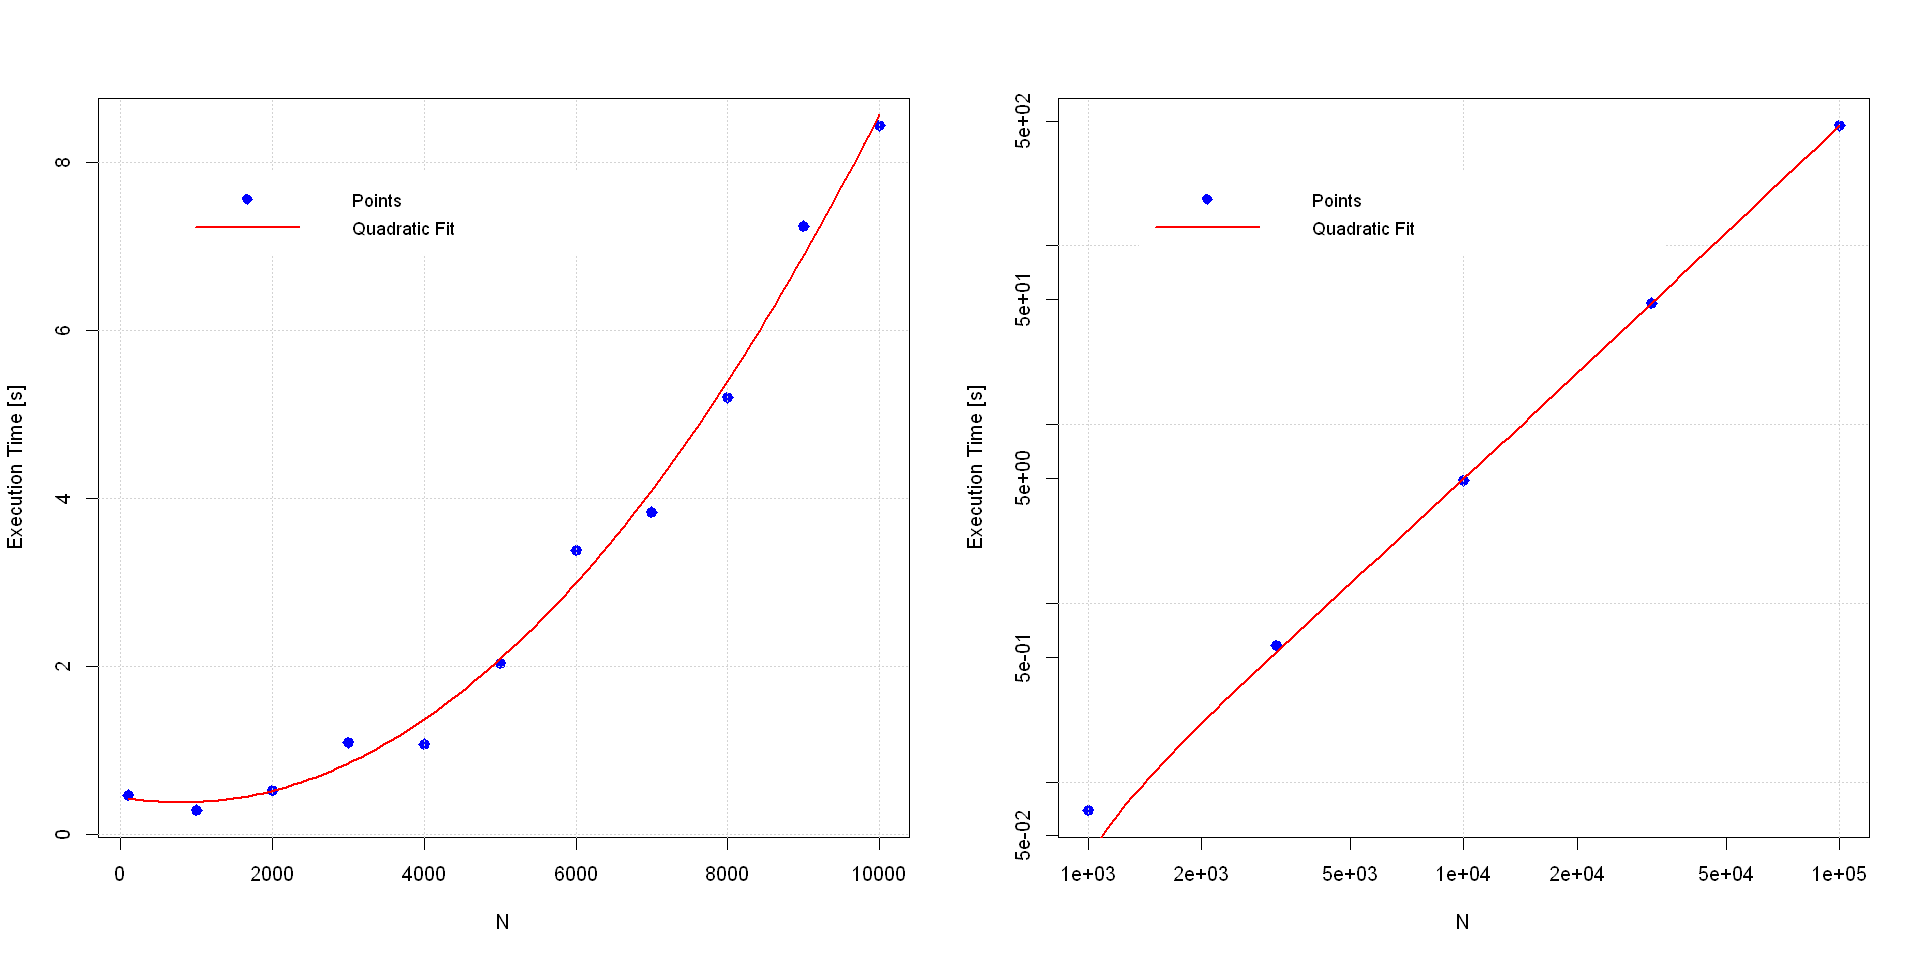

In [19]:
# plot results

fitted_func <- function(fit, x) {
      res <- as.numeric(fit$coefficients["(Intercept)"]) +
             as.numeric(fit$coefficients["x"]) * x +
             as.numeric(fit$coefficients["x2"]) * x**2
      return(res)
}

par(mfrow = c(1, 2))
options(repr.plot.width=16, repr.plot.height=8)

plot(N1, exec_time1, xlab = "N", ylab = "Execution Time [s]", col = "blue", pch = 10, lwd = 3)
grid()
curve(fitted_func(fit1, x), N1[1], N1[length(N1)],
      col = "red", lw = 2, add = T)
legend("topleft", inset=+0.1, legend = c("Points", "Quadratic Fit"),
      col = c("blue","red"), lty = c(NA, 1), pch = c(10, NA), lwd = c(3, 2),
      cex = 0.9, box.lty = 0, border = F)

plot(N2, exec_time2, xlab = "N", ylab = "Execution Time [s]", col = "blue", pch = 10, lwd = 3, log = "xy")
grid()
curve(fitted_func(fit2, x), N2[1], N2[length(N2)],
      col = "red", lw = 2, add = T)
legend("topleft", inset=+0.1, legend = c("Points", "Quadratic Fit"),
      col = c("blue","red"), lty = c(NA, 1), pch = c(10, NA), lwd = c(3, 2),
      cex = 0.9, box.lty = 0, border = F)

As expected, the data points follow a quadratic distribution quite nicely, with some slight deviations at lower $N$ for linear and constant effects.

## 3. Comparison with Other Binning Methods <a name="comparison"></a>

Other objective methods have been proposed to determine binning according to some optimization procedure.
We will now compare the Bayesian Block algorithm using different priors with the following:

- Square root: $K = \lceil \sqrt{N} \rceil$
- Sturges: $K = \lceil ln(N) \rceil + 1$  [[3]](#Sturges)
- Freedman-Diaconis: $h = 2 \frac{IQRi}{N^{1/3}}$, where $IQR$ is the interquartile range of the data  [[4]](#FreedmanDiaconis)

where $K$ is the number of bins and $h$ is their width.

### 3.1. Metrics <a name="comp_metrics"></a>

In order to quantitavely compare different methods we will use two metrics, introduced by Pollack. [[2]](#Pollack)

The first metric is designed to capture the visual appeal of the histogram by minimizing the number of bin-to-bin height fluctuations, hereafter referred to as "wiggles", that denote unwanted statistical fluctuations. The number of wiggles in a histogram is defined as:

$$ W_n = \sum \left[ sgn \left( f'\left(B_i \right) \right) \cdot sgn \left( f'\left(B_{i+1} \right) \right) = -1 \right]$$

where $f \left(B_i \right)$ is the finite first derivative of the function describing the height of block (or bin) $i$: this metric simply counts the number of adjacent opposite-sign first derivatives.

In [ ]:
## code here

In [ ]:
### description of second metric here

### 3.2. Results <a name="comp_results"></a>

## 4. Examples of Application  <a name="examples"></a>

### 4.1. Radioactive Source  Spectrum <a name="ex_radio"></a>

### 4.2. Higgs Physics <a name="ex_higgs"></a>

## 5. Bibliography <a name="bibliography"></a>

[2] B. Pollack *et al.*,
    [arXiv:1708.008 10](https://arxiv.org/abs/1708.00810)
    <a name="Pollack"></a>

[3] H. A. Sturges,
    Journal of the American Statistical Association  **21**, 65 (1926),
    https://doi.org/10.1080/01621459.1926.10502161.
    <a name="Sturges"></a>
                                             
[4] D. Freedman and P. Daiconis,
    Zeitschrift fur Wahrscheinlichkeitstheorie und verwandte Gebiete **57**, 453 (1981).
    <a name="FreedmanDiaconis"></a>

Test 

In [3]:
set.seed(48)
norm_data <- c(rnorm(2000,0,0.8),rnorm(2000,5,0.7),rnorm(2000,7,0.5))
N <- length(norm_data)
breaks = bayesian_blocks(norm_data, Prior="calibrated", p0 = 0.05)

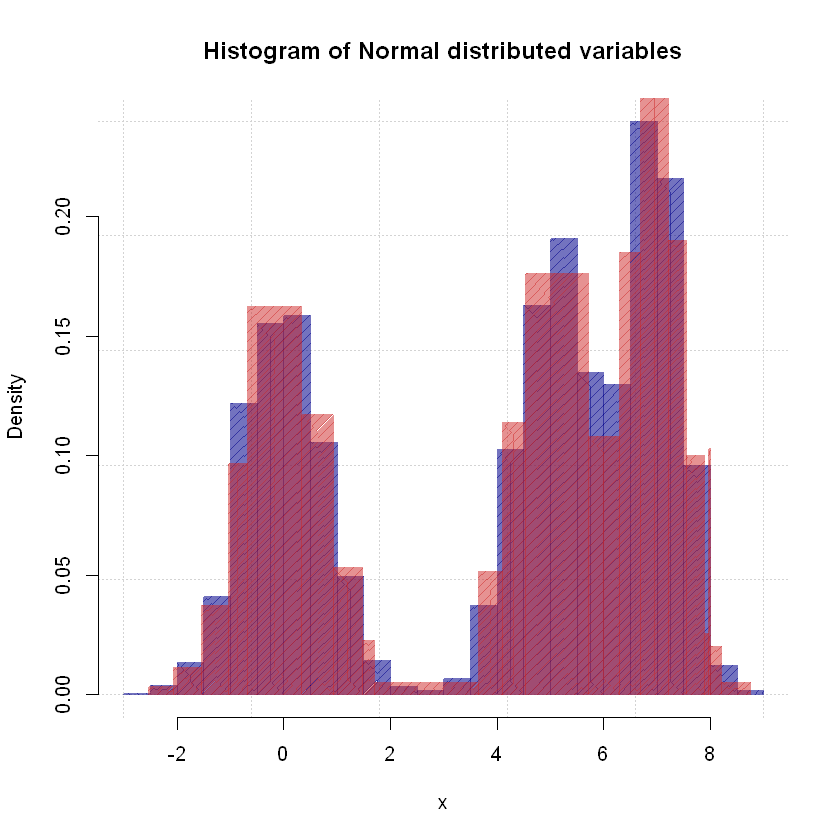

In [4]:
hist(norm_data,breaks="freedman-diaconis",freq=FALSE,col=scales::alpha('darkblue',.55),border=F, panel.first=grid(),density=200,
     xlab='x',ylab='Density',main=sprintf('Histogram of Normal distributed variables'))
g <- hist(norm_data,breaks=breaks,density=200,
     freq=FALSE,col=scales::alpha('firebrick3',.5),border=F,add=T)

In [12]:
#exec_time1 <- c(0.0172479152679443, 0.133802890777588, 0.338721036911011, 0.768672943115234, 
#                1.12476801872253, 1.64819598197937, 2.45492100715637, 2.97475099563599, 3.66642284393311,
#                4.35661911964417, 5.0487699508667)
#exec_time2 <- c(0.0695300102233887, 0.577858924865723, 4.86060404777527, 47.8130168914795, 470.706510066986)